# Access data from ASReview file

<div class="alert alert-warning">

The API is still under development and can change at any time without warning. 

</div>

Data generated using ASReview LAB is stored in an ASReview project file. Via the ASReview Python API, there are two ways to access the data in the ASReview (extension `.asreview`) file: Via the [project-API](reference.rst#asreviewproject) and the [state-API](reference.rst#module-asreview.state). The project API is for retrieving general project settings, the imported dataset, the feature matrix, etc. The state API retrieves data related directly to the reviewing process, such as the labels, the time of labeling, and the classifier used. 




## Example Data
To illustrate the ASReview Python API, the benchmark dataset `van_de_Schoot_2017` is used.  The project file `example.asreview` can be obtained by running ```asreview simulate benchmark:van_de_Schoot_2017 -s example.asreview```. 

The ASReview Python API can be used for project files obtained via the Oracle, Exploration, and Simulation mode. 

## Python Imports

In [1]:
import shutil
from pathlib import Path

import pandas as pd
from asreview import open_state
from asreview import ASReviewProject
from asreview import ASReviewData

## Project API
The ASReview project file is a zipped folder. To unzip the folder and store its contents in a temporary directory, use the following code: 

In [2]:
project_path = Path("tmp_data")
project_path.mkdir()
project = ASReviewProject.load('example.asreview', project_path)

The returned `project` instance is of type [ASReviewProject](generated/asreview.ASReviewProject.rst).

To inspect the project details, use the following code:

In [3]:
project.config

{'version': '1.0rc1+46.gb310417.dirty',
 'id': 'example',
 'mode': 'simulate',
 'name': 'example',
 'description': 'Simulation created via ASReview via command line interface',
 'authors': None,
 'created_at_unix': 1654172382,
 'datetimeCreated': '2022-06-02 14:19:42.822517',
 'reviews': [{'id': '23a4a370cba1433db3842b20a504ec82',
   'start_time': '2022-06-02 14:19:43.214958',
   'status': 'finished',
   'end_time': '2022-06-02 14:19:51.587138'}],
 'feature_matrices': [{'id': 'tfidf', 'filename': 'tfidf_feature_matrix.npz'}],
 'dataset_path': 'van_de_Schoot_2017.csv'}

The imported dataset is located at `/tmp_data/{project_name}/data/{dataset_filename}`, and can be inspected using the following code: 

In [4]:
dataset_fp = Path(project_path, project.config['id'], "data", project.config['dataset_path'])
dataset = ASReviewData.from_file(dataset_fp)
dataset.to_dataframe().head()

title  \
record_id                                                      
0               Manual for ASEBA School-Age Forms & Profiles   
1          Queensland Trauma Registry: A summary of paedi...   
2          Posttraumatic Stress Disorder: Scientific and ...   
3                            SOCIAL CLASS AND MENTAL ILLNESS   
4          Computerised test generation for cross-nationa...   

                                                    abstract keywords  \
record_id                                                               
0                                                                       
1                                                                       
2          This comprehensive overview of research and cl...            
3                                                                       
4          “‘Computerised Test Generation for Cross-Natio...            

                                                     authors    year  date  \
record_id                                                                    
0                          Achenbach, T. M., Rescorla, L. A.  2001.0  2001   
1                          Dallow, N., Lang, J., Bellamy, N.  2007.0  2007   
2          Ford, J. D., Grasso, D. J., Elhai, J. D., Cour...  2015.0   NaN   
3                        Hollingshead, A. B., Redlich, F. C.  1958.0   NaN   
4                                              Irvine, S. H.  2014.0   NaN   

           doi label_included  label_abstract_screening  duplicate_record_id  
record_id                                                                     
0          NaN              0                         0                  NaN  
1          NaN              0                         0                  NaN  
2          NaN              0                         0                  NaN  
3          NaN              0                         0                  NaN  
4          NaN              0                         0                  NaN

To obtain the content of the feature matrix, for example, the first row of the matrix, use the following code (note the matrix is in a sparse matrix format):

In [5]:
feature_extraction_id = project.feature_matrices[0]['id']
feature_matrix = project.get_feature_matrix(feature_extraction_id)
print(feature_matrix[0])

  (0, 20452)	0.35937211648312967
  (0, 18297)	0.26158369118434677
  (0, 13842)	0.3248271421716685
  (0, 9739)	0.38355660008860293
  (0, 3231)	0.7059309068495663
  (0, 2384)	0.22684547910949254


## State API

The data stored during the review process can be accessed as a pandas DataFrame using the following code:

In [6]:
with open_state('example.asreview') as state:
    df = state.get_dataset()

The returned `state` instance is of type [SQLiteState](generated/asreview.state.SQLiteState.rst).

In [7]:
df.to_csv('example_state.csv', index=False)
df.head()

record_id  label classifier query_strategy balance_strategy  \
0       2455      1       None          prior             None   
1       2677      0       None          prior             None   
2       2859      0         nb            max           double   
3       3406      0         nb            max           double   
4       1366      0         nb            max           double   

  feature_extraction  training_set               labeling_time notes  
0               None            -1  2022-06-02 14:19:45.069368  None  
1               None            -1  2022-06-02 14:19:45.069368  None  
2              tfidf             2  2022-06-02 14:19:45.163866  None  
3              tfidf             3  2022-06-02 14:19:45.179505  None  
4              tfidf             4  2022-06-02 14:19:45.195130  None

There are also multiple functions to get one specific type of data directly. For example, to obtain the labeling times and plot them in a graph, use the following code: 

<AxesSubplot:title={'center':'Time of labeling'}>

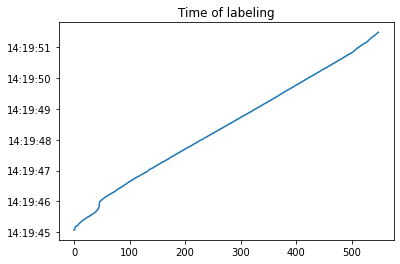

In [8]:
with open_state('example.asreview') as state:
    labeling_times = state.get_labeling_times()
pd.to_datetime(labeling_times).plot(title="Time of labeling")

By default, the records that are part of the prior knowledge are included in the results. To obtain the labels use the following code:

In [9]:
with open_state('example.asreview') as state:
    labels = state.get_labels(priors=False)
labels

0      0
1      0
2      0
3      0
4      0
      ..
542    0
543    0
544    0
545    0
546    1
Name: label, Length: 547, dtype: int64

To obtain the data corresponding to a specific record identifier, use the following code:

In [10]:
with open_state('example.asreview') as state:
    record_data = state.get_data_by_record_id(5176)
record_data

record_id  label classifier query_strategy balance_strategy  \
0       5176      0         nb            max           double   

  feature_extraction  training_set               labeling_time notes  
0              tfidf             5  2022-06-02 14:19:45.195130  None

## Cleanup
The following code removes the temporary folder that was created:

In [11]:
shutil.rmtree(project_path)